## Import Necessary Libraries

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_curve, auc, roc_auc_score, hamming_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from model_functions import get_scores, get_auc_scores, plot_roc_curve, show_cm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np
np.random.seed(2019)

## Load Dataset

In [105]:
ctg_df = pd.read_excel('CTG.xls', sheet_name='Raw Data')

Drop first row because empty. Drop last three rows because not actually data, just someone's scratch work

In [106]:
ctg_df = ctg_df.drop(0)
ctg_df = ctg_df[:-3]
ctg_df.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
1,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
5,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


Reset the index to start at 0.

In [107]:
ctg_df = ctg_df.reset_index()
ctg_df = ctg_df.drop('index', axis=1)

In [108]:
ctg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 40 columns):
FileName    2126 non-null object
Date        2126 non-null datetime64[ns]
SegFile     2126 non-null object
b           2126 non-null float64
e           2126 non-null float64
LBE         2126 non-null float64
LB          2126 non-null float64
AC          2126 non-null float64
FM          2126 non-null float64
UC          2126 non-null float64
ASTV        2126 non-null float64
MSTV        2126 non-null float64
ALTV        2126 non-null float64
MLTV        2126 non-null float64
DL          2126 non-null float64
DS          2126 non-null float64
DP          2126 non-null float64
DR          2126 non-null float64
Width       2126 non-null float64
Min         2126 non-null float64
Max         2126 non-null float64
Nmax        2126 non-null float64
Nzeros      2126 non-null float64
Mode        2126 non-null float64
Mean        2126 non-null float64
Median      2126 non-null float64
Vari

Drop columns that are irrelevant to problem (ex. FileName) or are classifications for another problem (A through SUSP).

In [109]:
ctg_df = ctg_df.drop(['FileName', 'Date', 'SegFile','b','e', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'], axis=1)
ctg_df.head()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,9.0,2.0
1,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,6.0,1.0
2,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,6.0,1.0
3,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,6.0,1.0
4,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,2.0,1.0


Create predictor and label DataFrames.

In [110]:
X = ctg_df.drop(['CLASS', 'NSP'], axis=1)
y = ctg_df['NSP']

Combine labels of 2 and 3 as we would definitely want an expert on hand if suspicious medical activity.

In [111]:
y = y.map({1.0: 0, 2.0:1, 3.0:1})

Look for possible categorical predictors and check for normality.

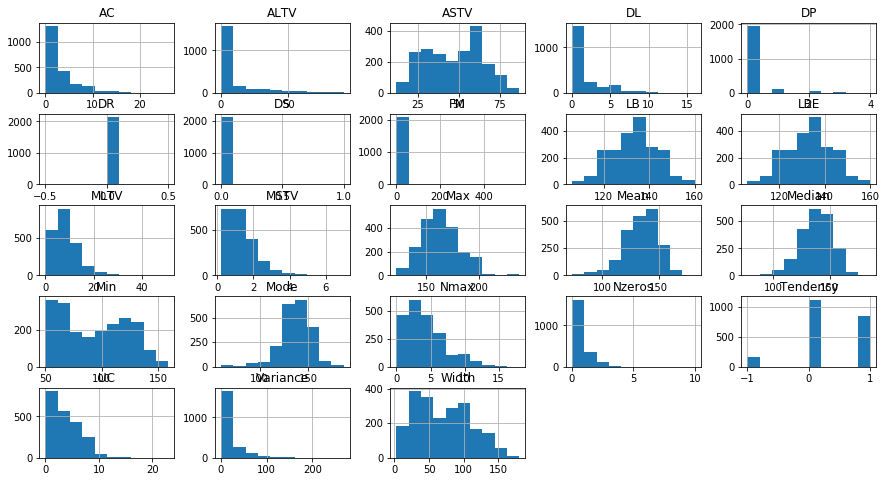

In [112]:
X.hist(figsize=(15, 8));

In [113]:
X['Tendency'].unique()

array([ 1.,  0., -1.])

Tendency is categorical so we will OneHotEncode after splitting the data.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [115]:
# pickle.dump(X_train, open('x_train.pkl', 'wb'))
# pickle.dump(X_test, open('x_test.pkl', 'wb'))
# pickle.dump(y_train, open('y_train.pkl', 'wb'))
# pickle.dump(y_test, open('y_test.pkl', 'wb'))

In [116]:
X_train = pickle.load(open('x_train.pkl', 'rb'))
X_test = pickle.load(open('x_test.pkl', 'rb'))
y_train = pickle.load(open('y_train.pkl', 'rb'))
y_test = pickle.load(open('y_test.pkl', 'rb'))

In [117]:
mapper = DataFrameMapper(
    [(["Tendency"], OneHotEncoder(categories='auto', drop='first')),]
    , df_out=True)

In [118]:
mapper.fit(X_train)

DataFrameMapper(default=False, df_out=True,
                features=[(['Tendency'],
                           OneHotEncoder(categorical_features=None,
                                         categories='auto', drop='first',
                                         dtype=<class 'numpy.float64'>,
                                         handle_unknown='error', n_values=None,
                                         sparse=True))],
                input_df=False, sparse=False)

In [119]:
train_output = mapper.transform(X_train)
train_output.head()

,Tendency_0,Tendency_1
835,0.0,1.0
1639,1.0,0.0
863,1.0,0.0
1017,1.0,0.0
2007,1.0,0.0


In [120]:
test_output = mapper.transform(X_test)
test_output.head()

,Tendency_0,Tendency_1
68,1.0,0.0
2124,0.0,1.0
387,1.0,0.0
1928,0.0,1.0
2005,1.0,0.0


In [121]:
X_train_full = pd.concat([X_train.drop('Tendency', axis=1), train_output], axis=1)
X_train_full.head().T

,835,1639,863,1017,2007
LBE,128.0,130.0,142.0,139.0,125.0
LB,128.0,130.0,142.0,139.0,125.0
AC,3.0,9.0,1.0,1.0,1.0
FM,0.0,2.0,0.0,0.0,1.0
UC,1.0,3.0,5.0,1.0,6.0
ASTV,16.0,52.0,44.0,38.0,63.0
MSTV,3.3,1.6,0.7,1.0,1.2
ALTV,0.0,0.0,40.0,0.0,0.0
MLTV,3.7,4.2,7.1,11.7,0.8
DL,5.0,5.0,0.0,0.0,6.0


In [122]:
X_test_full = pd.concat([X_test.drop('Tendency', axis=1), test_output], axis=1)
X_test_full.head()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency_0,Tendency_1
68,140.0,140.0,5.0,0.0,3.0,34.0,1.2,0.0,10.3,0.0,...,119.0,179.0,2.0,0.0,156.0,153.0,155.0,5.0,1.0,0.0
2124,140.0,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,0.0,1.0
387,129.0,129.0,4.0,11.0,1.0,37.0,1.2,0.0,8.6,0.0,...,93.0,195.0,8.0,0.0,187.0,157.0,153.0,137.0,1.0,0.0
1928,140.0,140.0,0.0,3.0,5.0,63.0,1.7,5.0,4.0,3.0,...,65.0,148.0,4.0,1.0,140.0,127.0,133.0,32.0,0.0,1.0
2005,125.0,125.0,3.0,1.0,4.0,60.0,1.3,0.0,7.5,6.0,...,68.0,164.0,6.0,1.0,110.0,120.0,120.0,34.0,1.0,0.0


# K-Nearest Neighbors

First attempted model is for KNN. For KNN we need to scale our predictors.

In [123]:
ss = StandardScaler()
scaled_X_train = ss.fit_transform(X_train_full)
scaled_X_test = ss.transform(X_test_full)

In [124]:
param_grid = {
    'n_neighbors': [5, 3, 10],
    'p': [2, 3, 4],
    'weights':['uniform', 'distance']
} 

In [125]:
knn = KNeighborsClassifier()
gscv = GridSearchCV(knn, param_grid=param_grid, cv=5)
gscv.fit(scaled_X_train, y_train)
best_params = gscv.best_params_
best_params

{'n_neighbors': 5, 'p': 3, 'weights': 'distance'}

In [126]:
knn = KNeighborsClassifier(n_neighbors=5, p=3, weights='distance')
knn.fit(scaled_X_train, y_train)
y_train_hat = knn.predict(scaled_X_train)
y_test_hat = knn.predict(scaled_X_test)

In [127]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 1.0
Testing Recall: 0.75
Training Hamming-Loss: 0.0
Testing Hamming-Loss: 0.08082706766917293


In [128]:
y_test_score = get_auc_scores(knn, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.7432982073230342
Testing AUC: 0.7569835875331565


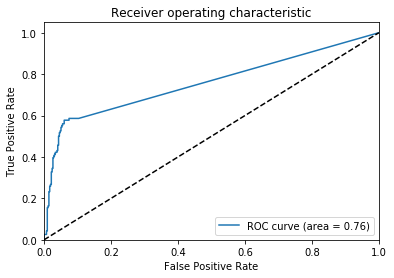

In [129]:
plot_roc_curve(y_test, y_test_score)

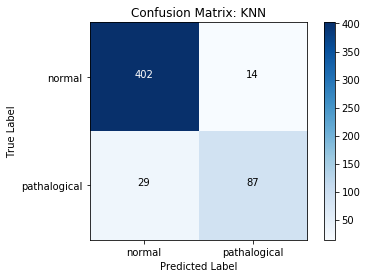

In [130]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathalogical'), model_name='KNN')

Probably not the best predictor as we want to minimize false negatives and 25% of the true positives are predicted as negatives.

# Decision Tree

In [131]:
dec_tree = DecisionTreeClassifier(max_depth=5)

In [132]:
dec_tree.fit(X_train_full, y_train)
y_train_hat = dec_tree.predict(X_train_full)
y_test_hat = dec_tree.predict(X_test_full)

In [133]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.8225352112676056
Testing Recall: 0.8103448275862069
Training Hamming-Loss: 0.05081555834378921
Testing Hamming-Loss: 0.06578947368421052


In [134]:
y_test_score = get_auc_scores(dec_tree, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.9558173902170082
Testing AUC: 0.9403804708222812


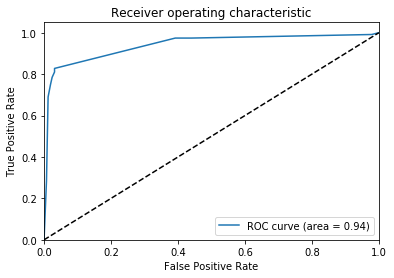

In [135]:
plot_roc_curve(y_test, y_test_score)

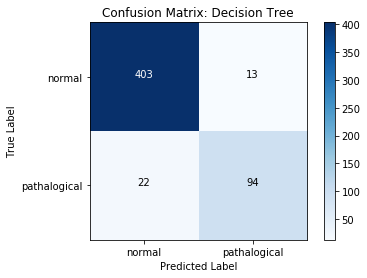

In [136]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathalogical'), model_name='Decision Tree')

This specific decision tree is not the best for the same reason as KNN. Grid Search to find better parameters for the Decision Tree.

In [137]:
dt_clf = DecisionTreeClassifier()

param_grid = {
    'max_depth': [3, 5, 8],
    'min_samples_split': [2, 4, 6],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

gs_dt = GridSearchCV(dt_clf, param_grid, cv=5)
gs_dt.fit(X_train_full, y_train)
best_params = gs_dt.best_params_
best_params

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 8,
 'min_samples_split': 4}

In [138]:
dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8, min_samples_split=4)
dt.fit(X_train_full, y_train)

y_train_hat = dt.predict(X_train_full)
y_test_hat = dt.predict(X_test_full)

In [139]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.9943661971830986
Testing Recall: 0.9482758620689655
Training Hamming-Loss: 0.015683814303638646
Testing Hamming-Loss: 0.05827067669172932


In [140]:
y_test_score = get_auc_scores(dt, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.9991974445543317
Testing AUC: 0.9570726956233422


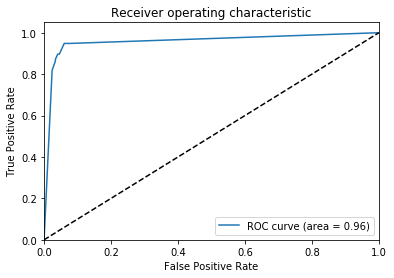

In [141]:
plot_roc_curve(y_test, y_test_score)

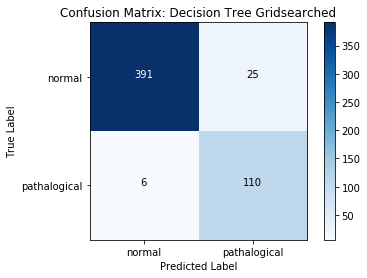

In [142]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathalogical'), model_name='Decision Tree Gridsearched')

# PCA

In [143]:
pca = PCA(n_components=3)
pca.fit(X_train_full)
principal_comps = pca.transform(X_train_full)
pca.components_

array([[-5.24361304e-02, -5.24361304e-02,  1.41305432e-02,
         1.92137617e-01,  9.08276962e-03, -9.89688046e-02,
         1.15448146e-02, -1.62117966e-01,  6.46531479e-03,
         2.68525698e-02,  8.25388576e-05,  3.20951958e-03,
         0.00000000e+00,  6.70981137e-01, -4.87917795e-01,
         1.83063342e-01,  3.84444564e-02,  4.05923057e-03,
        -1.06607662e-01, -1.33649313e-01, -9.80011261e-02,
         3.97742013e-01, -1.21479880e-03,  7.21633046e-04],
       [ 2.50597562e-02,  2.50597562e-02, -7.04004668e-04,
         9.79458469e-01, -9.18829249e-03, -1.52028464e-02,
        -2.14777674e-03,  4.44552870e-02,  1.24748990e-03,
        -9.59877698e-03, -6.57547066e-05,  8.01322369e-04,
        -0.00000000e+00, -1.31213798e-01,  1.09206669e-01,
        -2.20071291e-02, -2.21118555e-03, -2.38657021e-03,
         4.23196344e-02,  4.11451581e-02,  3.46166366e-02,
        -5.18981246e-02,  3.87526219e-04, -2.10438663e-04],
       [-2.54598438e-01, -2.54598438e-01, -4.04567987e

In [144]:
comps = pd.DataFrame(principal_comps, columns=['PC1', 'PC2', 'PC3'])
principal_comps_test = pca.transform(X_test_full)

In [145]:
dt_pca = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8, min_samples_split=6)
dt_pca.fit(principal_comps, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [146]:
y_test_hat = dt_pca.predict(principal_comps_test)
y_train_hat = dt_pca.predict(principal_comps)

In [147]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.7633802816901408
Testing Recall: 0.6120689655172413
Training Hamming-Loss: 0.07716436637390213
Testing Hamming-Loss: 0.15601503759398497


# Random Forest

In [148]:
rf = RandomForestClassifier(n_estimators=5)

In [149]:
rf.fit(X_train_full, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [150]:
y_train_hat = rf.predict(X_train_full)
y_test_hat = rf.predict(X_test_full)

In [151]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.9690140845070423
Testing Recall: 0.8017241379310345
Training Hamming-Loss: 0.00878293601003764
Testing Hamming-Loss: 0.06203007518796992


In [152]:
y_test_score = get_auc_scores(rf, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.9996078163898646
Testing AUC: 0.9546066810344829


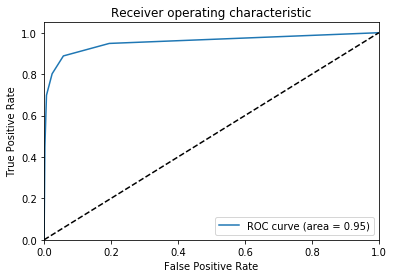

In [153]:
plot_roc_curve(y_test, y_test_score)

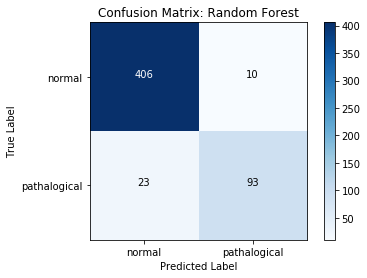

In [154]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathalogical'), model_name='Random Forest')

In [155]:
param_grid = {
    'n_estimators':[3, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 8],
    'min_samples_split': [2, 4, 6, 8],
    'class_weight': [None, 'balanced']
}

In [156]:
rf_clf = RandomForestClassifier()
gs_rf = GridSearchCV(rf_clf, param_grid=param_grid, cv=5)
gs_rf.fit(X_train, y_train)

best_params = gs_rf.best_params_
best_params

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_split': 4,
 'n_estimators': 9}

In [157]:
rf = RandomForestClassifier(class_weight=None, criterion='entropy',
                            max_depth=8, min_samples_split=4, n_estimators=9)

In [158]:
rf.fit(X_train_full, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [159]:
y_train_hat = rf.predict(X_train_full)
y_test_hat = rf.predict(X_test_full)

In [160]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.9464788732394366
Testing Recall: 0.8103448275862069
Training Hamming-Loss: 0.013174404015056462
Testing Hamming-Loss: 0.05639097744360902


In [161]:
y_test_score = get_auc_scores(rf, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.9989916902545215
Testing AUC: 0.9852557194960213


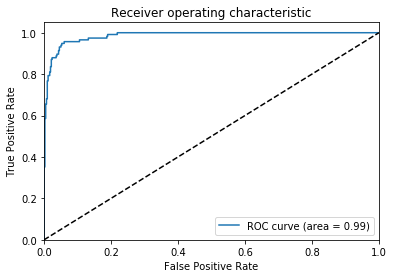

In [162]:
plot_roc_curve(y_test, y_test_score)

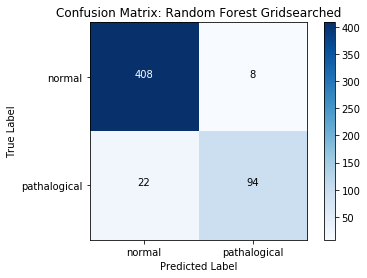

In [163]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathalogical'), model_name='Random Forest Gridsearched')

# XGBoost

In [164]:
boosted = xgb.XGBClassifier()

In [165]:
boosted.fit(X_train_full, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [166]:
y_train_hat = boosted.predict(X_train_full)
y_test_hat = boosted.predict(X_test_full)

In [167]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.9352112676056338
Testing Recall: 0.853448275862069
Training Hamming-Loss: 0.018820577164366373
Testing Hamming-Loss: 0.05263157894736842


In [168]:
y_test_score = get_auc_scores(boosted, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.9979424570018984
Testing AUC: 0.9880843832891247


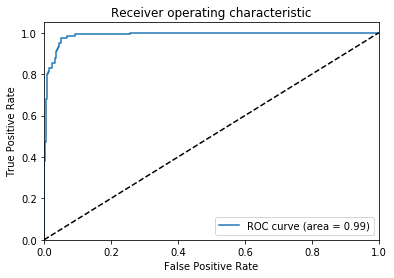

In [169]:
plot_roc_curve(y_test, y_test_score)

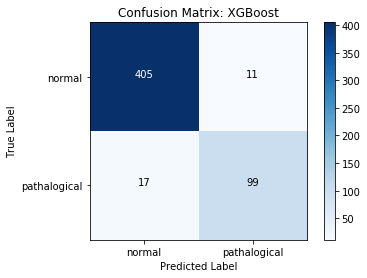

In [170]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathalogical'), model_name='XGBoost')

In [171]:
param_grid = {
    'learning_rate': [.1, .01, .5, 1],
    'max_depth': [3, 5, 8],
    'n_estimators': [10, 100, 1000],    
}
gs_xgb = GridSearchCV(xgb.XGBClassifier(), param_grid=param_grid, cv=5)
gs_xgb.fit(X_train_full, y_train)
best_params = gs_xgb.best_params_
best_params

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000}

In [172]:
boost_clf = xgb.XGBClassifier(learning_rate=0.01, max_depth=8, n_estimators=1000)
boost_clf.fit(X_train_full, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [173]:
y_train_hat = boost_clf.predict(X_train_full)
y_test_hat = boost_clf.predict(X_test_full)

In [174]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 1.0
Testing Recall: 0.9396551724137931
Training Hamming-Loss: 0.0
Testing Hamming-Loss: 0.03195488721804511


In [175]:
y_test_score = get_auc_scores(boost_clf, X_train_full, X_test_full, y_train, y_test)

Training AUC: 1.0
Testing AUC: 0.9873383620689655


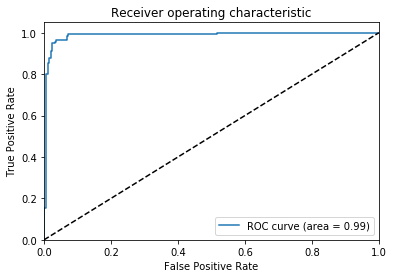

In [176]:
plot_roc_curve(y_test, y_test_score)

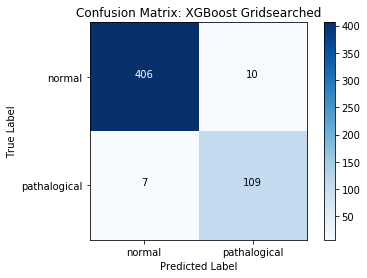

In [177]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathalogical'), model_name='XGBoost Gridsearched')